In [2]:
import cv2 as cv
import numpy as np
import scipy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Simple image displaying

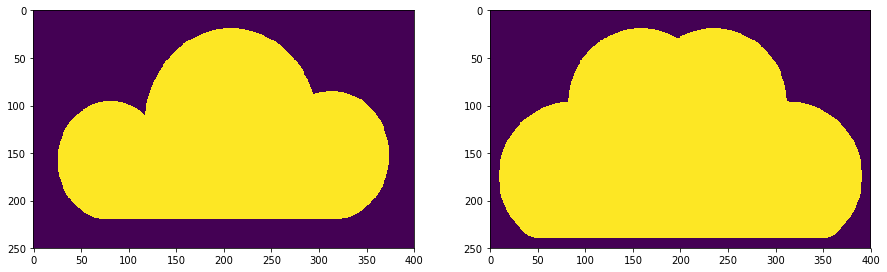

In [3]:
w = 400
h = 250

cloud_1_raw = cv.imread("Images/cloud_1.png")
cloud_2_raw = cv.imread("Images/cloud_2.png")
cloud_1_raw = cv.resize(cloud_1_raw, (w, h))
cloud_2_raw = cv.resize(cloud_2_raw, (w, h))

R = np.zeros((h, w))
T_raw = np.zeros((h, w))

# Convert images to normalized 2D numpy arrays, with 1 for black
for i in range(h):
    for j in range(w):
        R[i][j] = 1 - sum(cloud_1_raw[i][j]) // 665
        T_raw[i][j] = 1 - sum(cloud_2_raw[i][j]) // 665

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(R)
plt.subplot(1, 2, 2)
plt.imshow(T_raw)

# Function definitions

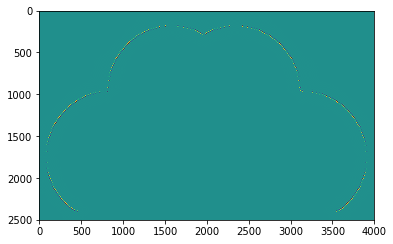

In [10]:
x = np.arange(w)
y = np.arange(h)
T = sp.interpolate.RectBivariateSpline(x, y, T_raw.T, s=1e-1) # Interpolation of our image, transposed to be on x/y

# Plot the interpolation on a new grid to ensure it worked
Img = T(np.linspace(0, w-1, w*10), np.linspace(0, h-1, h*10), dx=1, dy=1) # evaluation of the function on the grid
plt.imshow(Img.T) # drawing the interpolation, transposed so x is column, y is rows
plt.show()

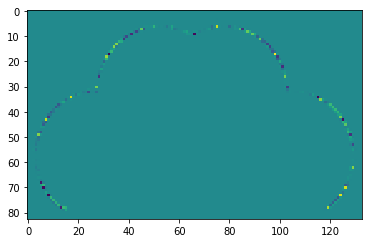

In [6]:
# Linearly transforms interpolated function T from parameters p and returns new function that works on integers/numpc arracs
# p = p1, p2, p3, p4, p5, p6
# p1-p4 form a matrix:
# (p1 p2)
# (p3 p4)
# Which defines a linear transformation about the center, (p5, p6) is translation in (x, y)
def trafo(T, p, w, h):
    def ev(x, y, dx=0, dy=0):
        
        # Translate to center
        x0 = x - w // 2
        y0 = y - h // 2

        #Apply transformation and translation
        x = p[0] * x0 + p[1] * y0 + w // 2 - p[4]
        y = p[2] * x0 + p[3] * y0 + h // 2 - p[5]
        
        if dx == 0 and dy == 0:
            return T(x, y)
        elif dx == 1 and dy == 0:
            return T(x, y, dx=1) * p[0] + T(x, y, dy=1) * p[2]
        elif dx == 0 and dy == 1:
            return T(x, y, dx=1) * p[1] + T(x, y, dy=1) * p[3]
        elif dx == 1 and dy == 1:
            return p[3] * (T(x, y, dx=2) * p[2] + T(x, y, dx=1, dy=1) * p[0]) + p[1] * (T(x, y, dx=2) * p[2] + T(x, y, dx=1, dy=1) * p[0]) # Second derivatives on f/g are 0
        return 0
        
    def mapped_T(x, y, dx=0, dy=0):
        if isinstance(x, (int, float)) and isinstance(y, (float, int)):
            return ev(x, y, dx=dx, dy=dy)
        elif isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
            # We need to handle broadcasting ourselves to avoid skewing
            out_grid = np.zeros((len(x), len(y)))
            for xi in range(len(x)):
                for yi in range(len(y)):
                    out_grid[xi][yi] = ev(x[xi], y[yi], dx=dx, dy=dy)
            return out_grid
            
    return mapped_T

T_transformed = trafo(T, [1, 0, 0, 1, 0, 0], w, h)
# Plot the transformed T
Z = T_transformed(np.linspace(0,w-1, w // 3), np.linspace(0, h-1, h//3), dx=1, dy=1) # evaluation of the function on the grid
plt.imshow(Z.T) # drawing the function
plt.show()

In [24]:
# The "cost" associated with a particular transformation
# TODO: implement spline-based transformations to allow derivatives to be computed
# With jacobian, cost function is easy to evaluate

In [ ]:
# To optimize the cost based on parameters, simply pass to scipy optimize.